# Streaming Data Transformation Pipeline

This Notebook demonstrates the utilization of the Apache Beam Framework to develop streaming data ingestion, transformation and sink.

In [3]:
import logging
import json
import time
import traceback

import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options import pipeline_options
from apache_beam.io.gcp.pubsub import ReadFromPubSub
from apache_beam.io.gcp.bigquery import BigQueryDisposition, WriteToBigQuery
from apache_beam.io import WriteToText

from apache_beam.runners.interactive.interactive_runner import InteractiveRunner
import apache_beam.runners.interactive.interactive_beam as ib
from apache_beam.runners import DataflowRunner

import google.auth

# from utils.utils import publish_to_topic
# from IPython.core.display import display, HTML

## Interactive Apache Beam Runner

The Apache Beam data processing framework supports various "runners".

The "Interactive Runner" comes handy for demonstration of the basic Apache Beam concepts.

Let's demonstrate a data ingestion from Pub/Sub, apply some simple transformations using Apache Beam.
The Interactive Runner allows us to peak at the result.

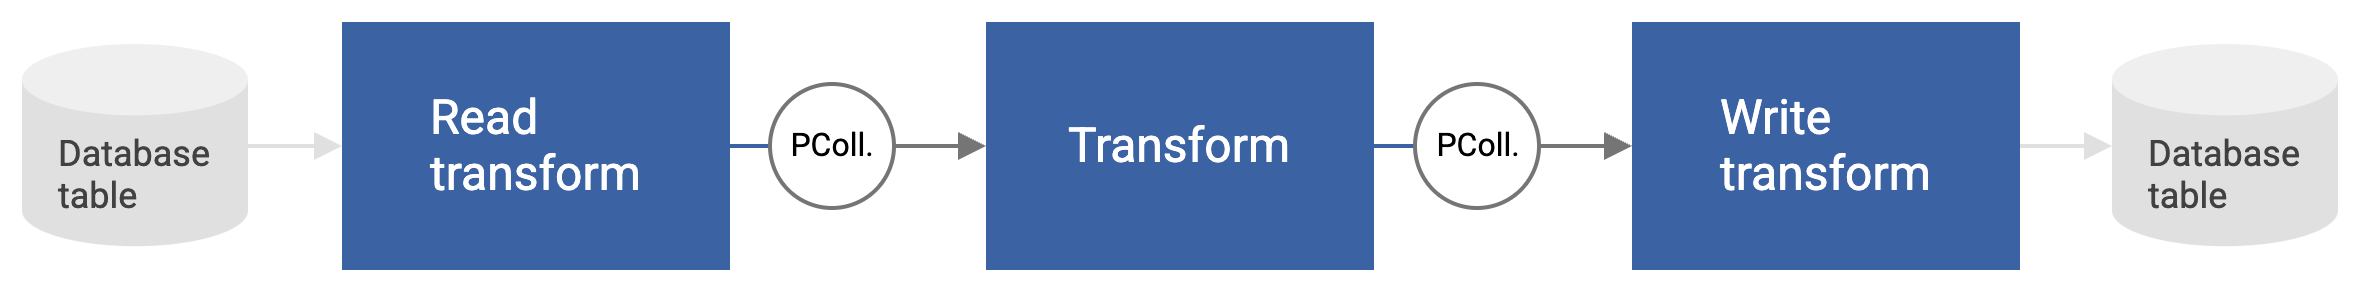

On the highest level, Apache Beam abstracts data processing into Transforms and Pcollections.

Important Python Syntax here is:<br>
`Resulting PCollection` = (`Initial PCollection` | `Transformation Name` >> `Transformation User Code`)<br>
<br>
`|` Pipe operator corresponds to .apply().<br>
`>>` Separates an optional transformation name string from the actual transformation.

Let's continue setting some basic pipeline options...

In [15]:
# Setting some basic pipeline options.
project = google.auth.default()[1]

options = pipeline_options.PipelineOptions(
    streaming=True,
    project=project
)

In [16]:
# Telling the interactive runner to listen for events for one minute.
ib.options.recording_duration = '1m'

... and defining the actual pipeline.

The pipeline listens to the given Pub/Sub topic, parses the received message for it's json content and applies an arbitrary transformation on every record. Once we send messages to the Pub/Sub topic, we can see the resulting PCollections printed out.

In [12]:
# Defining a pipeline object.
p = beam.Pipeline(InteractiveRunner(), options=options)

# Defining the Pub/Sub Subscription to read from.
subscription = "projects/jp-sandbox-359611/subscriptions/ecommerce_interactive_beam"

# Defining the pipeline.
pubsub = (p | "Read Topic" >> ReadFromPubSub(subscription=subscription) # Listining to Pub/Sub.
            | "Parse json" >> beam.Map(json.loads) # Parsing json from message string.
            | "Drop Col" >> beam.Map(lambda input: {'event_datetime': input['event_datetime'], # Dropping and renaming columns.
                                                    'event': input['event'],
                                                    'user_id':  input['user_id'],
                                                    'client_id': input['client_id'],
                                                    'page': input['page'],
                                                    'page_previous': input['page_previous']})
         )

ib.show(pubsub) # Display resulting PCollection in Notebook.

INFO:apache_beam.runners.direct.direct_runner:Running pipeline with DirectRunner.
INFO:apache_beam.runners.direct.direct_runner:Running pipeline with DirectRunner.


<IPython.core.display.Javascript object>

## Serverless Beam Data Processing using the Dataflow Runner

The Dataflow Runner allows running any Apache Beam pipeline completely serverless.

In [7]:
# logging.getLogger().setLevel(logging.INFO)

#### TODO: Let's create the necessary GCP resources (CLI)

In [10]:
def streaming_pipeline(project, region="us-central1"):
    
    topic = "projects/{}/topics/ecommerce_interactive_beam".format(project)
    table = "{}:retail_dataset.interactive_beam_sink".format(project)
    schema = "event_datetime:DATETIME, event:STRING, user_id:STRING, client_id:STRING, page:STRING, page_previous:STRING"
    bucket = "gs://interactive-df"
    
    # Defining pipeline options.
    options = PipelineOptions(
        streaming=True,
        project=project,
        region=region,
        staging_location="%s/staging" % bucket,
        temp_location="%s/temp" % bucket,
        subnetwork='regions/us-central1/subnetworks/terraform-network'
    )

    p = beam.Pipeline(DataflowRunner(), options=options)
    
    # Defining the transformed PCollection.
    pubsub = (p | "Read Topic" >> ReadFromPubSub(subscription=subscription)
                | "To Dict" >> beam.Map(json.loads) 
                | "Drop Col" >> beam.Map(lambda input: {'event_datetime': input['event_datetime'],
                                                    'event': input['event'],
                                                    'user_id':  input['user_id'],
                                                    'client_id': input['client_id'],
                                                    'page': input['page'],
                                                    'page_previous': input['page_previous']})
                
             )
    
    # Wriring the PCollection to BigQuery as sink.
    pubsub | "Write To BigQuery" >> WriteToBigQuery(table=table, schema=schema,
                                  create_disposition=BigQueryDisposition.CREATE_IF_NEEDED,
                                  write_disposition=BigQueryDisposition.WRITE_APPEND)
        
    return p.run()

In [11]:
pipeline = streaming_pipeline(project)
print("\n PIPELINE RUNNING \n")

INFO:apache_beam.runners.portability.stager:Downloading source distribution of the SDK from PyPi
INFO:apache_beam.runners.portability.stager:Executing command: ['/root/apache-beam-2.40.0/bin/python', '-m', 'pip', 'download', '--dest', '/tmp/tmpu5duw0t9', 'apache-beam==2.40.0', '--no-deps', '--no-binary', ':all:']
INFO:apache_beam.runners.portability.stager:Staging SDK sources from PyPI: dataflow_python_sdk.tar
INFO:apache_beam.runners.portability.stager:Downloading binary distribution of the SDK from PyPi
INFO:apache_beam.runners.portability.stager:Executing command: ['/root/apache-beam-2.40.0/bin/python', '-m', 'pip', 'download', '--dest', '/tmp/tmpu5duw0t9', 'apache-beam==2.40.0', '--no-deps', '--only-binary', ':all:', '--python-version', '37', '--implementation', 'cp', '--abi', 'cp37m', '--platform', 'manylinux1_x86_64']
E0824 20:02:21.328921117    2472 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
INFO:apache_beam.runners.portab


 PIPELINE RUNNING 

